In [1]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [2]:
pwd

'/content/drive/MyDrive'

In [23]:
!pip install tensorflow-gpu -i https://pypi.tuna.tsinghua.edu.cn/simple/



Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [27]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
import bz2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas  as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from tqdm import tqdm
stop_words = set(stopwords.words('english'))
from nltk.stem import wordnet 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
lemma = wordnet.WordNetLemmatizer()

In [8]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


## data loading

In [6]:
def get_data(file):
  labels = []
  texts = []
  for line in tqdm(bz2.BZ2File(file)):
    x = line.decode("utf-8")
    labels.append(int(x[9])-1)
    texts.append(x[10:].strip())
  return np.array(labels), texts

In [7]:
train_label , train_text = get_data("/content/drive/MyDrive/train.ft.txt.bz2")

3600000it [02:05, 28744.54it/s]


In [8]:
test_label, test_text = get_data("/content/drive/MyDrive/test.ft.txt.bz2")

400000it [00:13, 28851.16it/s]


## data cleaning

In [11]:
def process_text(text):
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub("[" u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    new=[]
    text=text.split()
    stop=set(stopwords.words('english'))
    for i in text:
        if i not in stop:
            new.append(i)
    new=" ".join(new)
    return new

In [12]:
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    lemmas = [lemma.lemmatize(word, pos ='v') for word in word_tokens]
    lemmas = " ".join(lemmas)
    return lemmas

In [ ]:
clean_txt=[]
for i in tqdm(train_text):
    txt = process_text(i)
    txt = lemmatize_word(txt)
    clean_txt.append(txt)

In [16]:
clean_txt_test=[]
for i in tqdm(test_text):
    txt = process_text(i)
    txt = lemmatize_word(txt)
    clean_txt_test.append(txt)

100%|██████████| 400000/400000 [05:32<00:00, 1204.63it/s]


In [9]:
import pickle

In [15]:
filename = 'text.pkl'
filename_test = 'text_test.pkl'

In [17]:
#pickle.dump(clean_txt, open(filename, 'wb'))
pickle.dump(clean_txt_test, open(filename_test, 'wb'))

In [26]:
data = pickle.load(open(filename, 'rb'))
data_test = pickle.load(open(filename_test, 'rb'))

## data preparation

In [16]:
vocab_size = 10000
embedding_dim = 64
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [20]:
token=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
token.fit_on_texts(clean_txt)

word_index=token.word_index
seq_train=token.texts_to_sequences(clean_txt)

pad_train=pad_sequences(seq_train,maxlen=max_length,padding="post",truncating="post")

In [21]:
filename = 'train_pad_data.pkl'
pickle.dump(pad_train, open(filename, 'wb'))

In [22]:
filename = 'token.pkl'
pickle.dump(token, open(filename, 'wb'))

In [10]:
token = pickle.load(open("token.pkl", 'rb'))

In [42]:
len(clean_txt_test)

400000

In [43]:
seq_test=token.texts_to_sequences(clean_txt_test)
pad_test=pad_sequences(seq_test,maxlen=120,padding="post",truncating="post")

In [44]:
pad_test.shape

(400000, 120)

In [11]:
pad_train = pickle.load(open("train_pad_data.pkl", 'rb'))

In [46]:
filename = 'test_pad_data.pkl'
pickle.dump(pad_test, open(filename, 'wb'))

In [12]:
pad_test = pickle.load(open("test_pad_data.pkl", 'rb'))

In [13]:
pad_train.shape

(3600000, 120)

In [14]:
pad_test.shape

(400000, 120)

## model preparing

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.LeakyReLU(alpha=0.05),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(500),
    tf.keras.layers.LeakyReLU(alpha=0.05),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 64)           640000    
                                                                 
 flatten_3 (Flatten)         (None, 7680)              0         
                                                                 
 dense_9 (Dense)             (None, 500)               3840500   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 500)               0         
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 500)              

## data spliting

In [18]:
x_train,x_test,y_train,y_test = train_test_split(pad_train,train_label,test_size=.3,random_state=42,stratify=train_label)

## model training

In [29]:
num_epochs = 1
history = model.fit(x_train, y_train, batch_size=1036,epochs=num_epochs, validation_data=(x_test, y_test))

2433/2433 [==============================] - 73s 29ms/step - loss: 0.2318 - accuracy: 0.9040 - val_loss: 0.2111 - val_accuracy: 0.9153


In [30]:
model.save("mymodel")

INFO:tensorflow:Assets written to: mymodel/assets


## model evalution

In [31]:
pred = model.predict(pad_test)

In [33]:
test_label[0]

1

In [35]:
pred[0]

1

In [34]:
pred = [1 if x >= 0.5 else 0 for x in pred]

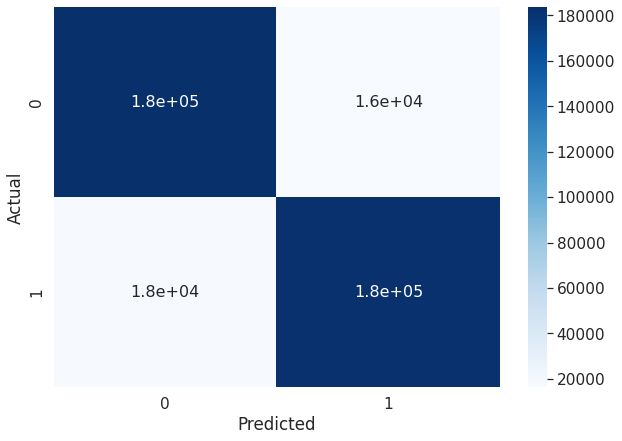

In [36]:
data = confusion_matrix(test_label, pred)
df_cm = pd.DataFrame(data, columns=np.unique(test_label), index = np.unique(test_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [39]:
print(classification_report(test_label,pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92    200000
           1       0.92      0.91      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



<Figure size 432x288 with 0 Axes>

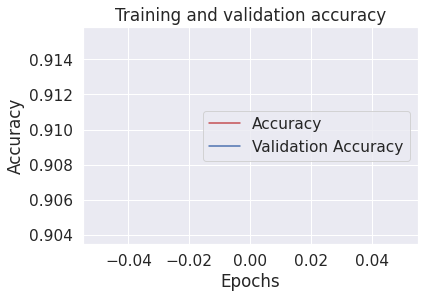

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()